In [74]:
from Utils.preprocessing import *
from Utils.pipelineComponents import *
from Utils.preprocessing import *
from scipy.stats import spearmanr
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

RANDOM_STATE = 2024

# Webscraping Portion

In [3]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("/Users/amanda/Documents/School/MY1S3/QF632/Project/jobs_in_data.csv")
sample_data_b = pd.read_csv("/Users/amanda/Documents/School/MY1S3/QF632/Project/QF632_Project_2_b.csv.csv")
sample_data_c = pd.read_csv("/Users/amanda/Documents/School/MY1S3/QF632/Project/QF632_Project_2_c.csv.csv")
sample_data_d = pd.read_csv("/Users/amanda/Documents/School/MY1S3/QF632/Project/Glassdoor_Salary_Cleaned_Version.csv")

In [4]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"
roles = ["data scientists", "data analyst", "data storytellers", "data insights", "research scientist", "business data analyst",
        "data analytics", "data engineer", "machine learning", "ml engineer", "ai architect"]

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    dfs_base = pd.read_html(url)
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    dfs_var = pd.read_html(url)
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(56733, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,TYPE,Unnamed: 6
1053,AMAZON WEB SERVICES INC,DATA ENGINEER I,76981,"SEATTLE, WA",04/07/2021,10/03/2021,data engineer,NaN
509,COMPUCITY INC,DATA ANALYST,72000,"CHICAGO, IL",03/14/2018,09/10/2018,data analyst,NaN
8603,IDEXCEL INC,DATA ENGINEER,110000,"PLANO, TX",08/29/2023,09/07/2023,data engineer,NaN
157,SUNNOVA ENERGY CORPORATION,DATA ANALYTICS AND REPORTING MANAGER,120000,"HOUSTON, TX",08/07/2020,08/10/2020,data analytics,NaN
11874,UPSTART NETWORK INC,DATA ENGINEER,150000,"MILPITAS, CA",12/15/2020,01/11/2021,data engineer,NaN


# Data Analysis

In [5]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.iloc[:, :-1].reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})
all_df2["y"] =  pd.to_numeric(all_df2["y"]) / 1000

print(all_df2.shape)
all_df2.sample(5)

(52246, 9)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
16782,THE UNIVERSITY OF TEXAS MD ANDERSON CANCER CENTER,RESEARCH SCIENTIST,60.780,"HOUSTON, TX",2022-01-05,2022-04-01,research scientist,2022,TX
26010,AMAZON DEVELOPMENT CENTER US INC,RESEARCH SCIENTIST II,117.250,"GLENDALE, CA",2021-09-07,2021-09-13,research scientist,2021,CA
22829,FACEBOOK INC,RESEARCH SCIENTIST,171.770,"MENLO PARK, CA",2018-03-21,2018-08-08,research scientist,2018,CA
14895,PRINCETON GLOBALSYNTHESIS LLC,RESEARCH SCIENTIST,73.820,"LEVITTOWN, PA",2023-07-01,2023-08-01,research scientist,2023,PA
31345,HK INFOTECH LLC,DATA ENGINEER,76.045,"COLUMBUS, OH",2023-06-15,2023-10-01,data engineer,2023,OH


## Numerical Features
- yoy growth of median salary in each industry?

## Categorical Features
- Not sure if there is a way to further categorize the data into bigger subgroups (i.e., segregating state to urban and rural areas)

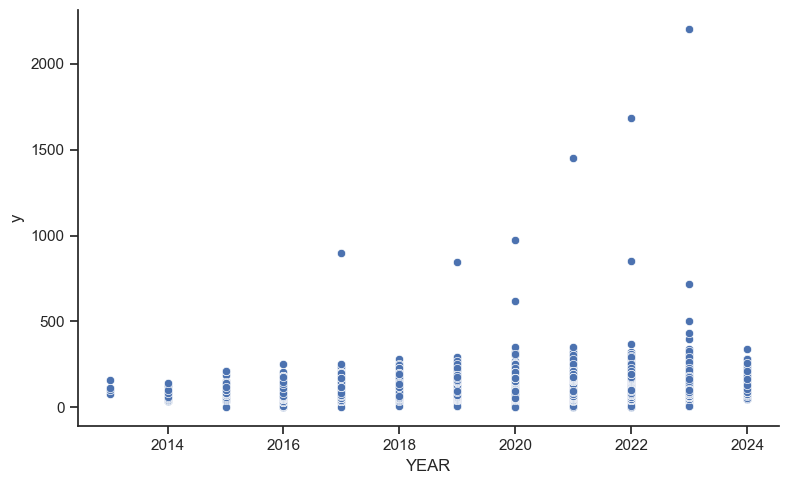

In [49]:
sns.relplot(data=all_df2, x='YEAR', y='y',aspect=1.61)
plt.show()

In [ ]:
sns.set(style='ticks')

sns.relplot(data=all_df2, x='YEAR', y='y', hue='STATE',aspect=1.61)
plt.show()

In [43]:
#plt.rcParams['figure.figsize'] = (fig_width, 6)
#plt.rcParams['figure.dpi'] = 100

<Figure size 5200x1000 with 0 Axes>

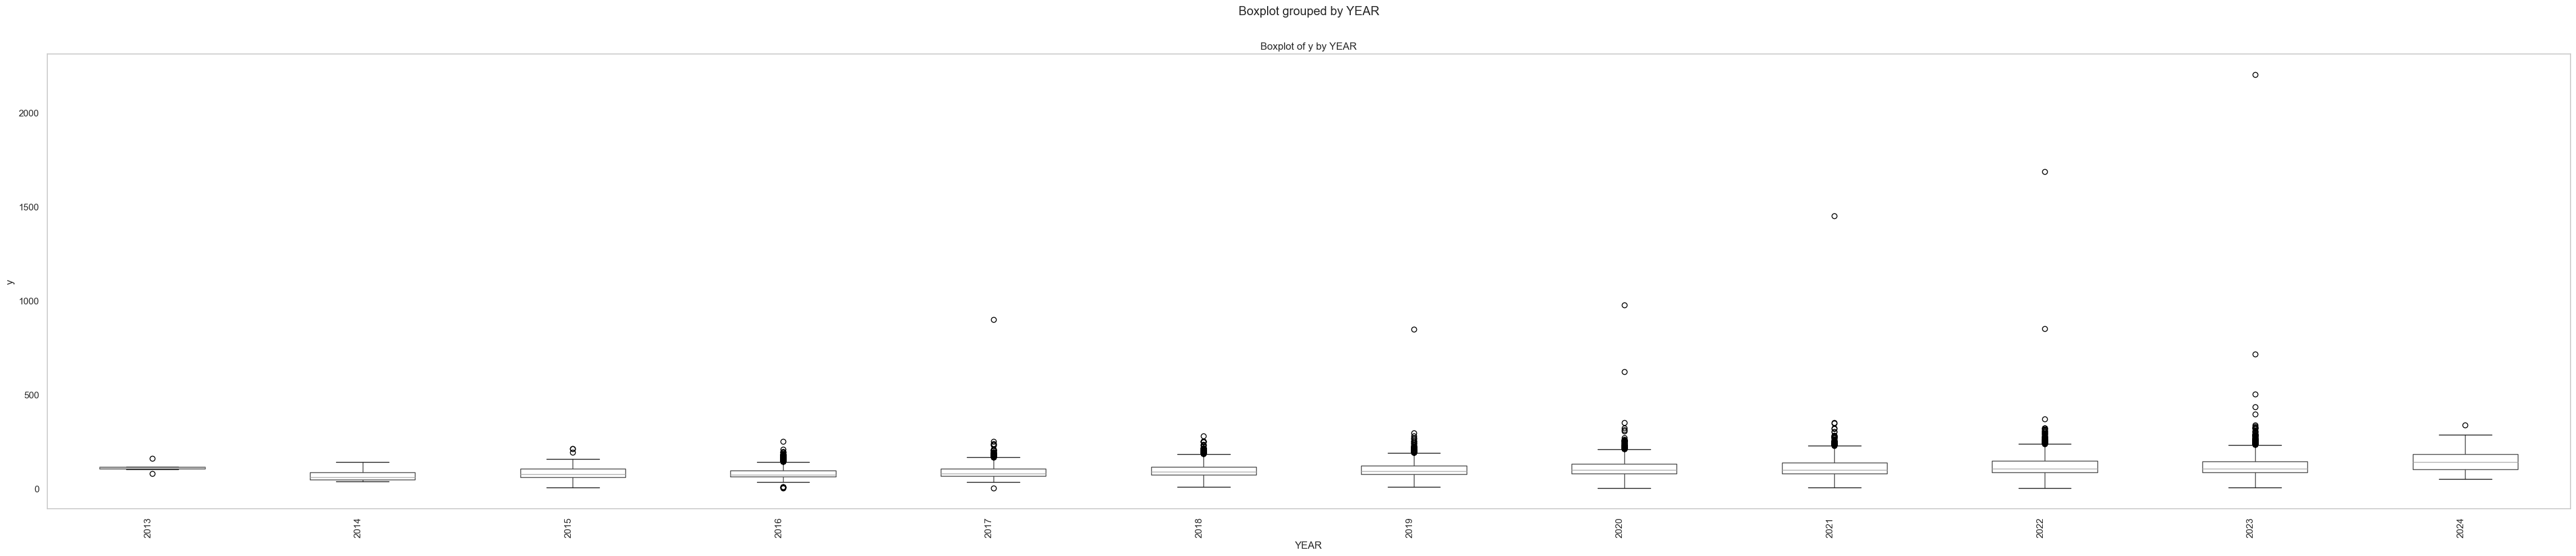

In [69]:
#Preliminary analysis of YEAR variable
plt.figure(figsize=(fig_width, 10))
all_df2.boxplot(column='y', by='YEAR', grid=False)
plt.title('Boxplot of y by YEAR')
plt.xlabel('YEAR')
plt.xticks(rotation=90, ha='right')
plt.ylabel('y')
plt.tight_layout
plt.show()

- Some conclusion about year
- Maybe we can do yoy change

<Figure size 5200x1000 with 0 Axes>

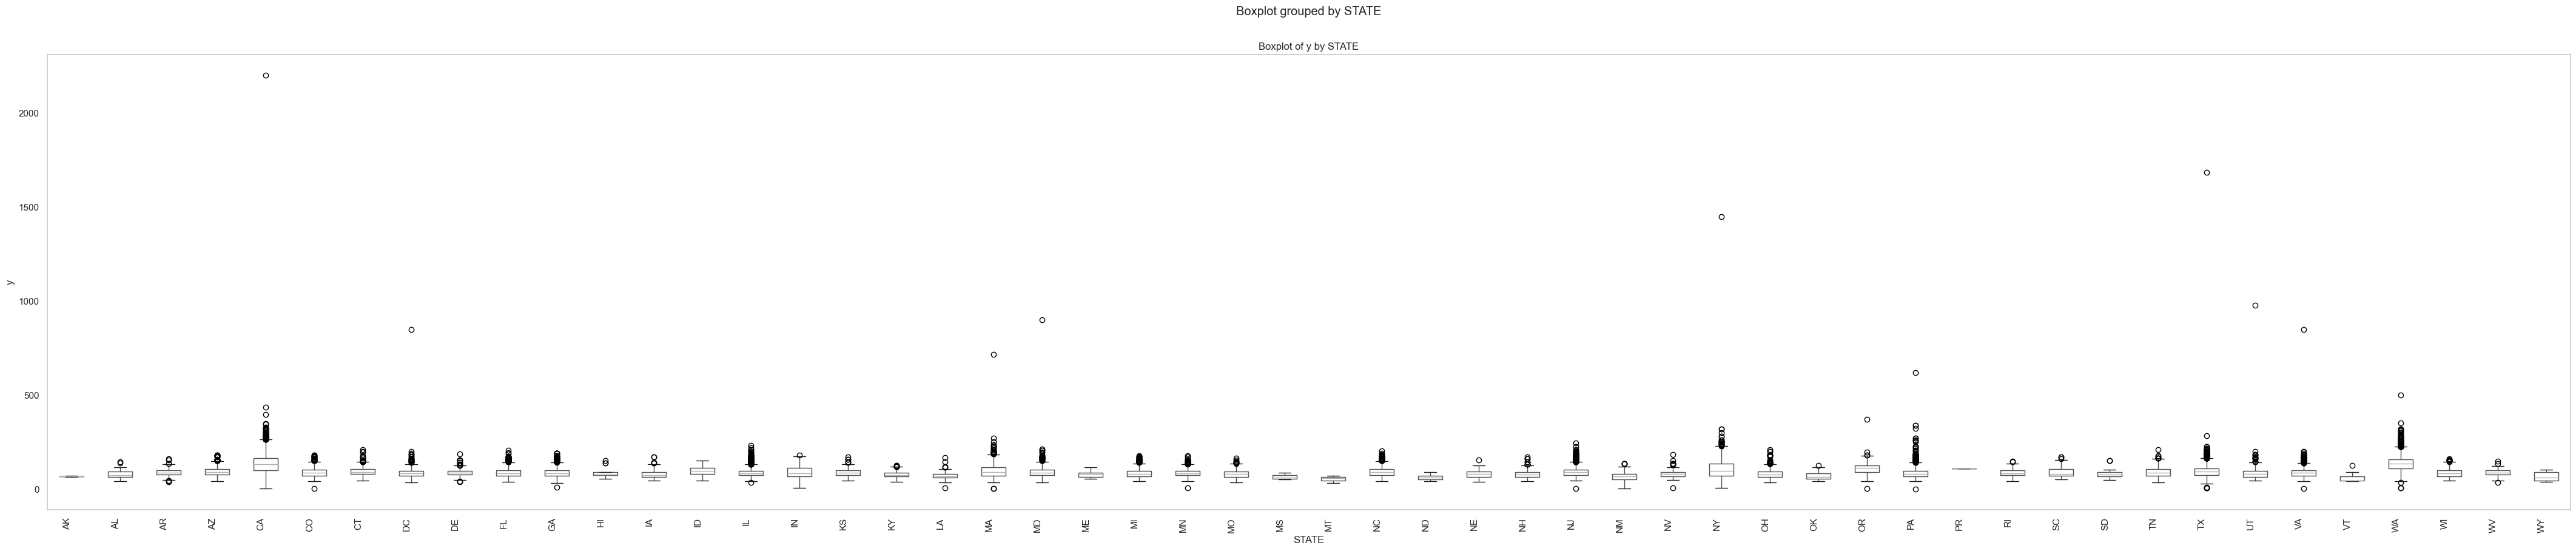

In [55]:
#Preliminary analysis of STATE variable
plt.figure(figsize=(fig_width, 10))
all_df2.boxplot(column='y', by='STATE', grid=False)
plt.title('Boxplot of y by STATE')
plt.xlabel('STATE')
plt.xticks(rotation=90, ha='right')
plt.ylabel('y')
plt.tight_layout
plt.show()

- Some conclusion about state
- Agree we can expand to urban/rural? or smth else, population density or number of companies in state? etc

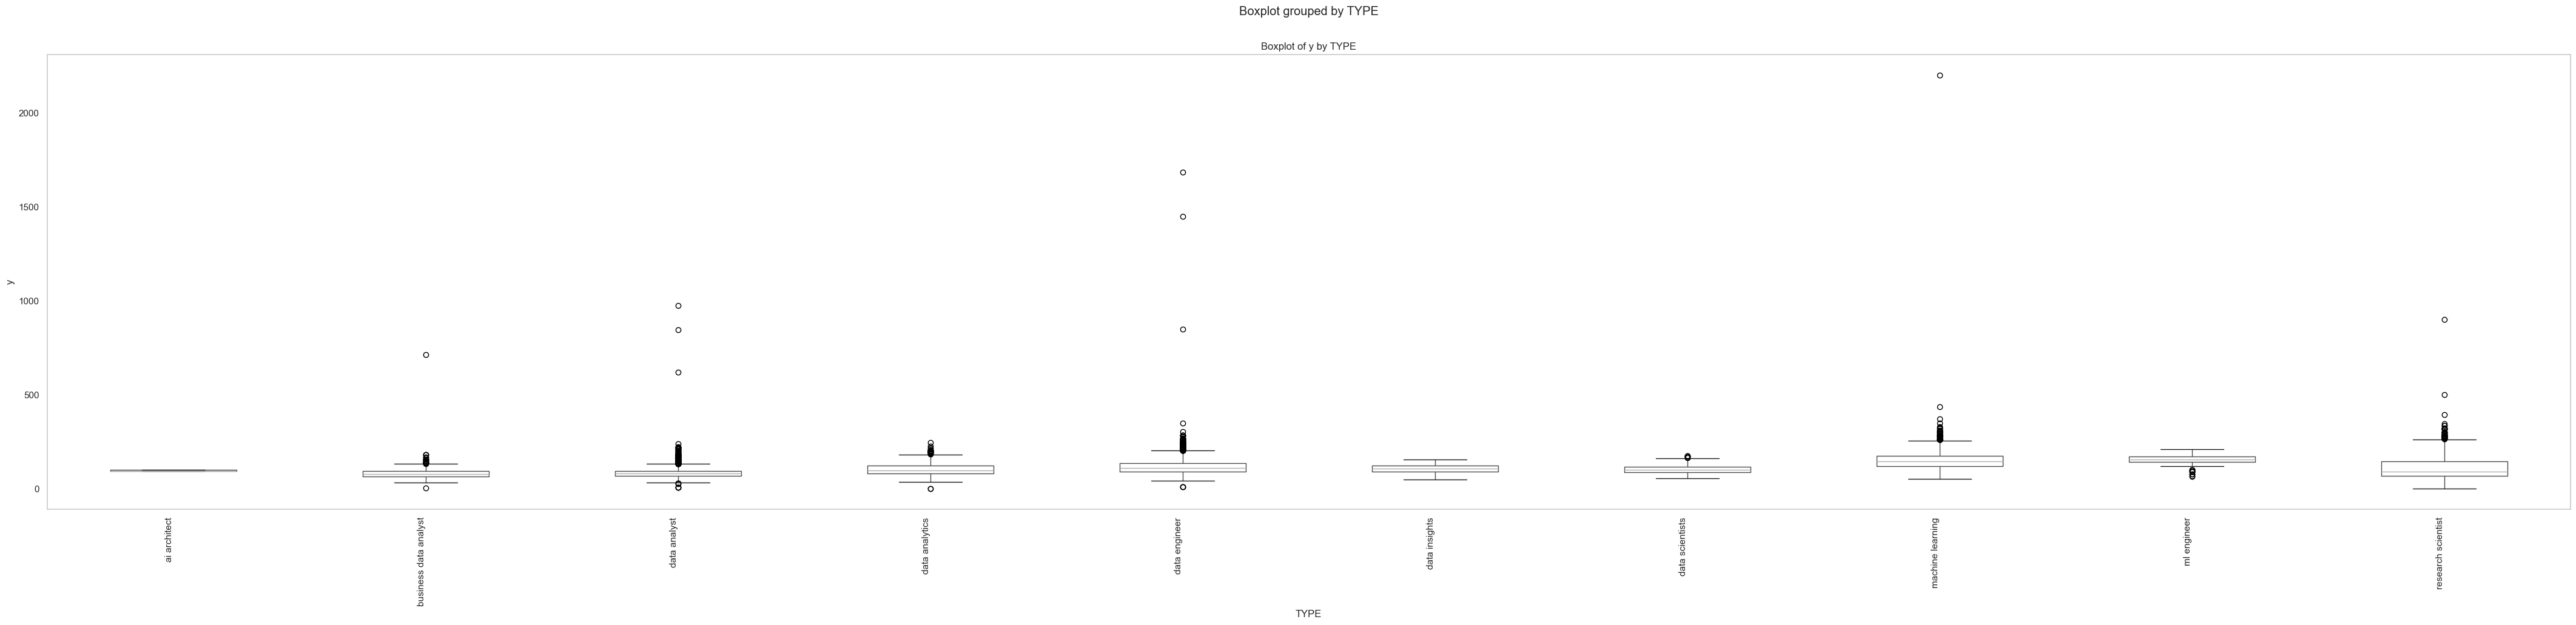

In [67]:
#Preliminary analysis of TYPE variable
#plt.figure(figsize=(fig_width, 10))
all_df2.boxplot(column='y', by='TYPE', grid=False)
plt.title('Boxplot of y by TYPE')
plt.xlabel('TYPE')
plt.xticks(rotation=90, ha='right')
plt.ylabel('y')
plt.tight_layout
plt.show()

- Some conclusion about type

/Users/amanda/DataspellProjects/QF632_Project/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanda/DataspellProjects/QF632_Project/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanda/DataspellProjects/QF632_Project/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


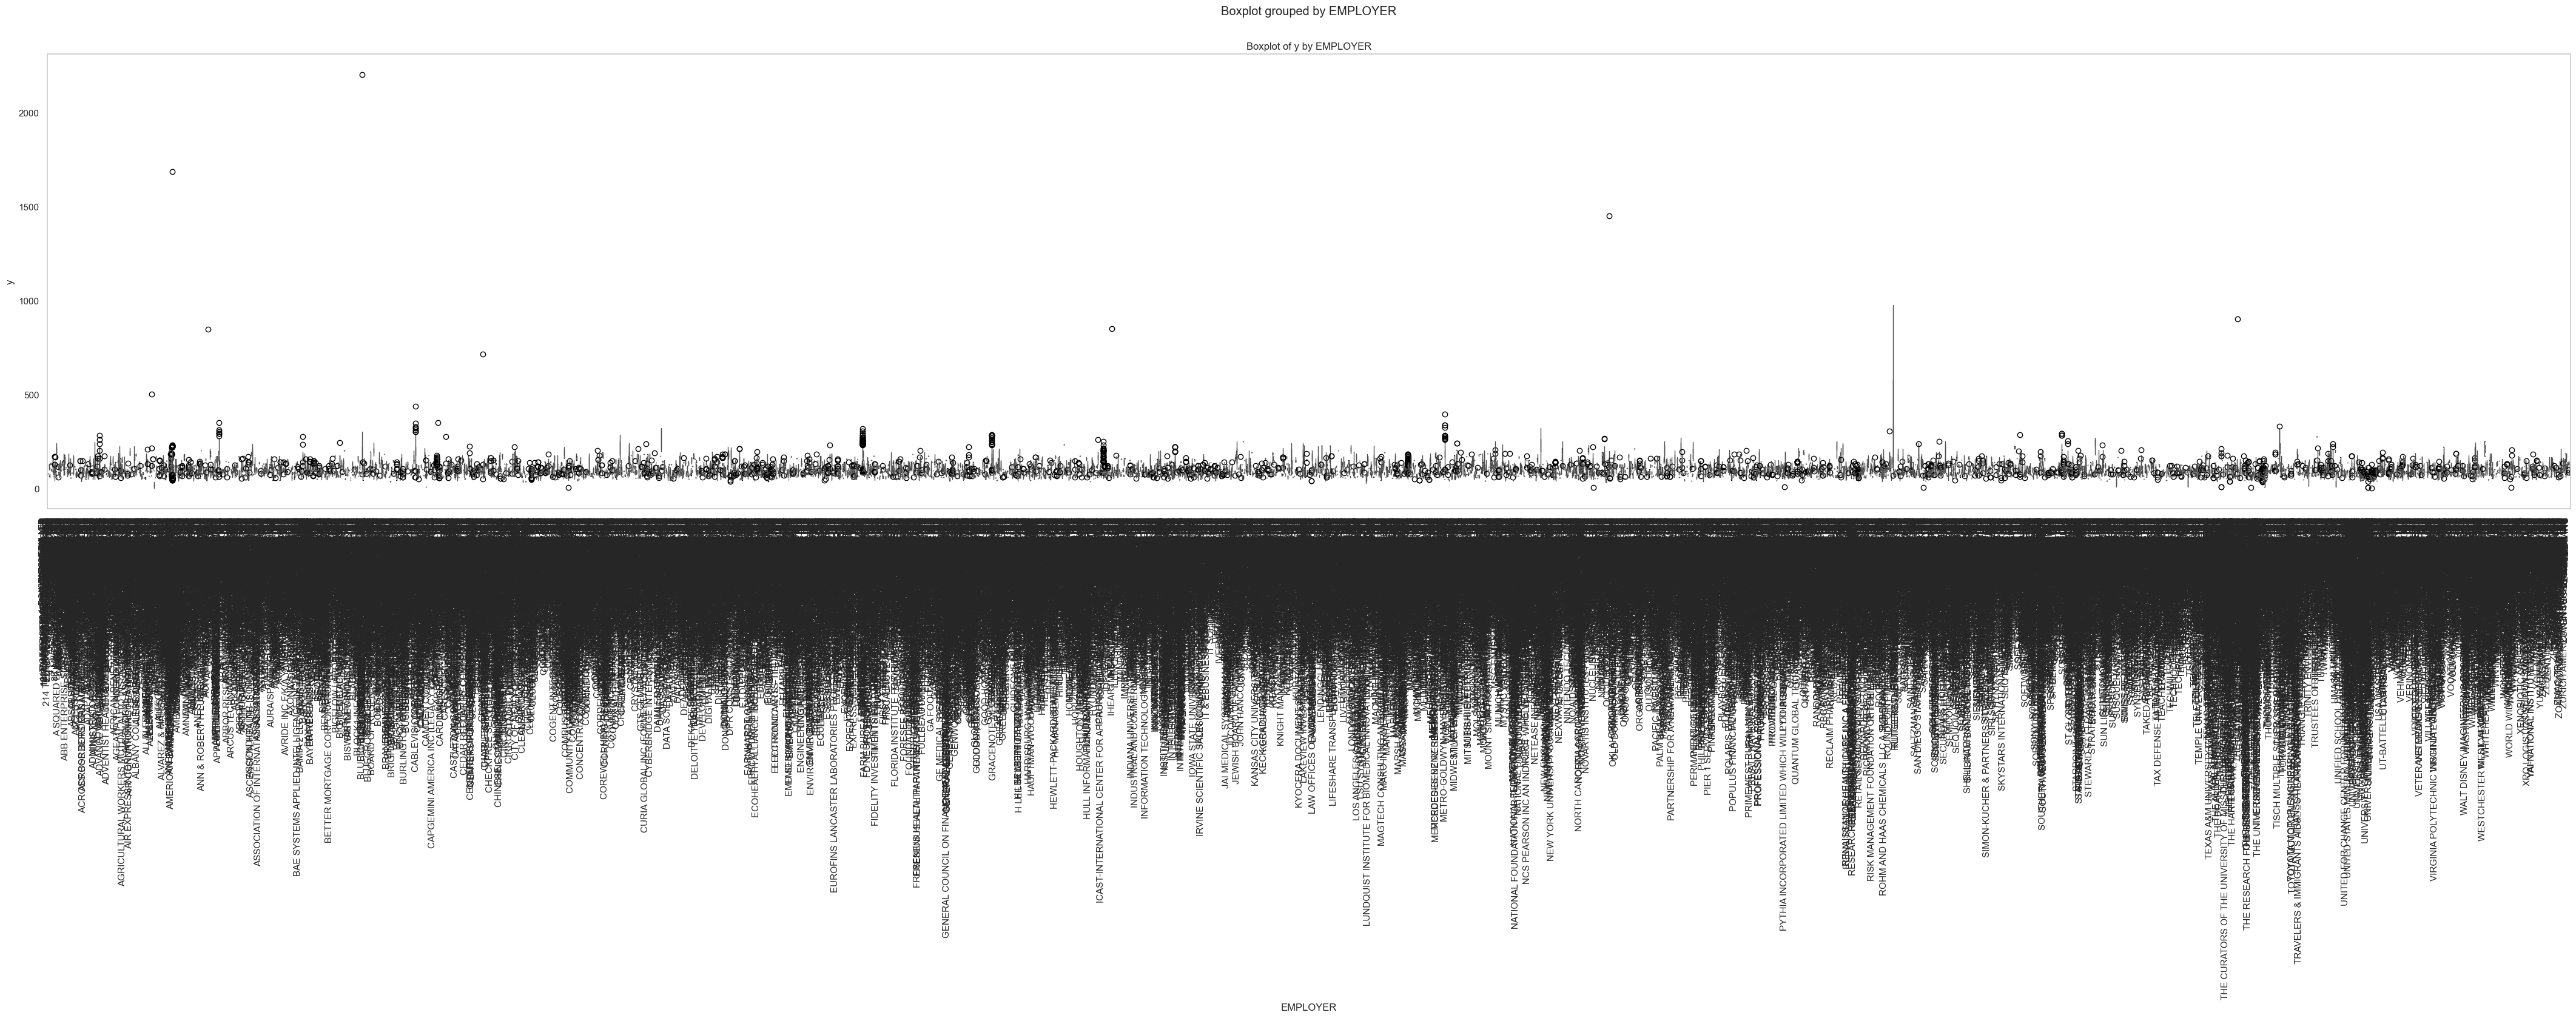

In [68]:
#Preliminary analysis of EMPLOYER variable
#plt.figure(figsize=(fig_width, 10))
all_df2.boxplot(column='y', by='EMPLOYER', grid=False)
plt.title('Boxplot of y by EMPLOYER')
plt.xlabel('EMPLOYER')
plt.xticks(rotation=90, ha='right')
plt.ylabel('y')
plt.tight_layout
plt.show()

- Some conclusion about employer; not sure if we should link it to size/valuation of company and analyse top 10 or smth, else this is not useful

In [ ]:
#excluding outliers 4 times above IQR
Q1 = all_df2['y'].quantile(0.25)
Q3 = all_df2['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 4 * IQR
filtered_df = all_df2[(all_df2['y'] >= lower_bound) & (all_df2['y'] <= upper_bound)]

plt.figure(figsize=(fig_width, 10))
filtered_df.boxplot(column='y', by='STATE', grid=False)
plt.title('Boxplot of y by STATE')
plt.xlabel('STATE')
plt.xticks(rotation=90, ha='right')
plt.ylabel('y')
plt.tight_layout
plt.show()


## Feature Selection

<Figure size 600x600 with 0 Axes>

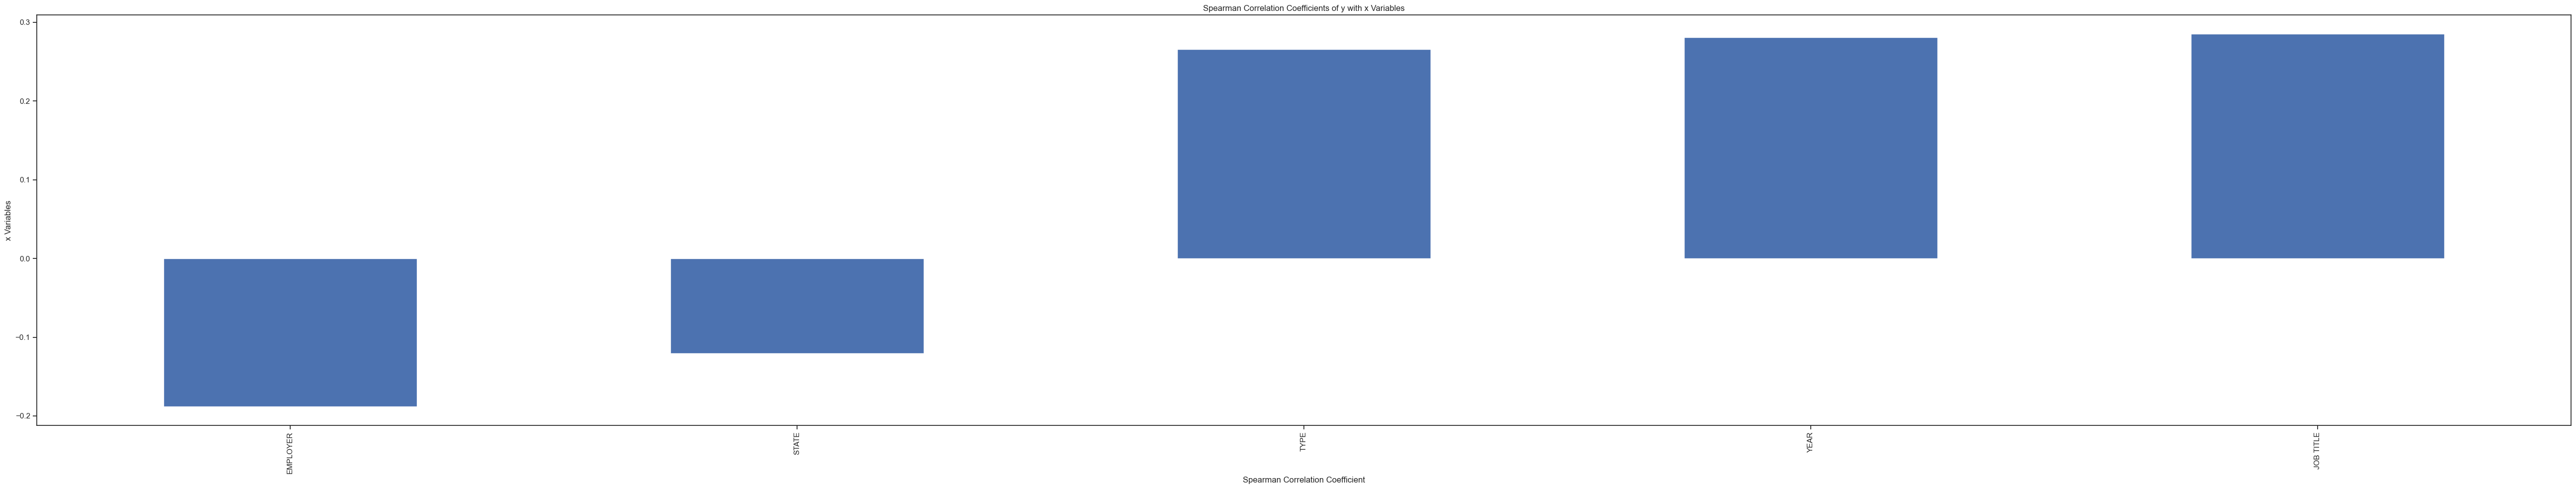

In [90]:
# Variable ranking using Spearman's rank correlation coefficient
all_df3 = all_df2[['y', 'YEAR', 'STATE', 'TYPE','EMPLOYER','JOB TITLE']]
x_variables = [col for col in all_df3.columns if col != 'y']
spearman_corr = all_df3[x_variables].apply(lambda x: spearmanr(all_df3['y'], x)[0])
spearman_corr_df = spearman_corr.to_frame(name='Spearman Correlation')


plt.figure(figsize=(6, 6))
spearman_corr_df.sort_values(by='Spearman Correlation').plot(kind='bar', legend=False)
plt.title('Spearman Correlation Coefficients of y with x Variables')
plt.xlabel('Spearman Correlation Coefficient')
plt.ylabel('x Variables')
plt.tight_layout()
plt.show()